In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Conducir un análisis exploratorio sobre los datos en WAR_class_dev.csv. Visualice la distribución de las variables y de la variable objetivo. Verifique si hay valores
faltantes (NaN), datos duplicados o desbalanceo entre clases. Analice también la
posible presencia de correlaciones fuertes entre los features. (Pandas Cheat Sheet)

In [10]:
from Problema1.src.visualization import explore_data

df_dev = pd.read_csv("Problema2/data/raw/WAR_class_dev.csv")
df_test = pd.read_csv("Problema2/data/raw/WAR_class_test.csv")

explore_data(df_dev)

Fragmento aleatorio de muestras


,poss,mp,raptor_total,war_total,pace_impact,war_class
3484,5781.050811,2804.605979,2.316829,8.360228,0.081252,3
6192,3397.458856,1761.258819,-4.868591,-2.161768,0.430384,1
5681,3027.153705,1509.615304,-5.481085,-1.625643,0.449211,1
5944,2109.771535,819.916134,-7.611042,-2.339916,0.328744,1
5034,3421.114204,1532.085473,-5.531518,-1.690872,-0.192544,1
2295,2411.166914,1388.126980,-1.496102,0.177395,-0.467777,2
5023,2666.972169,946.345518,-5.751651,-1.977782,0.448683,1



Rango de valores de cada columna


,poss,mp,raptor_total,war_total,pace_impact,war_class
min,-414.390684,-235.333650,-43.449330,-6.589665,-6.935191,1.0
max,9329.401575,4264.461247,32.904816,28.762877,11.193450,3.0



Categorías con valores faltantes
 Series([], )

Filas duplicadas: 0


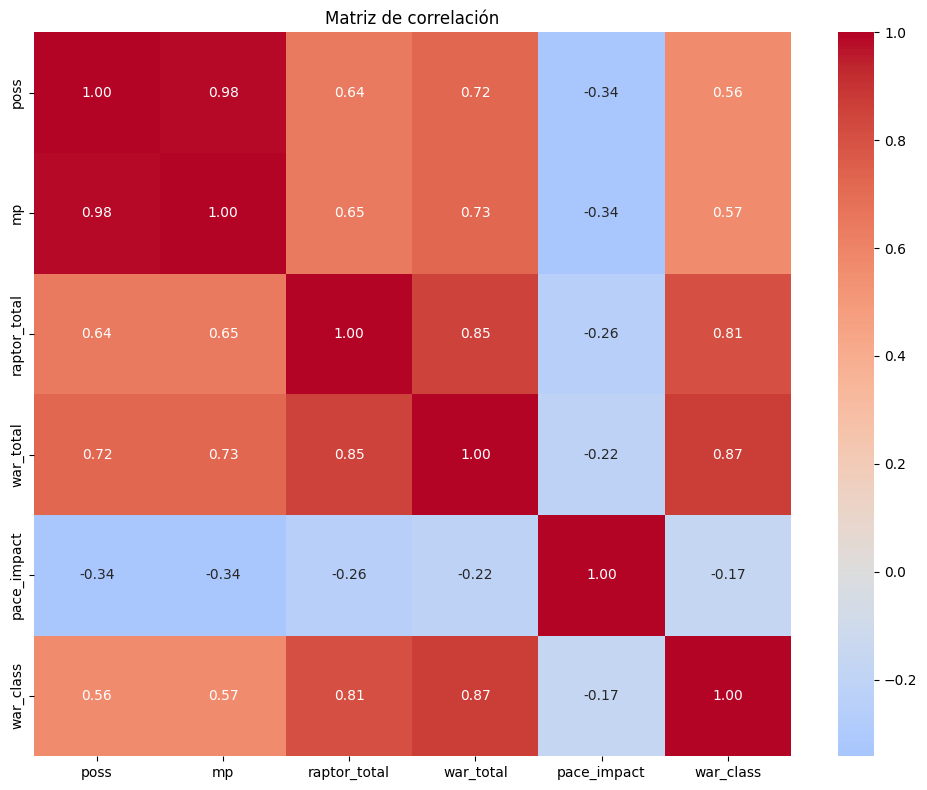

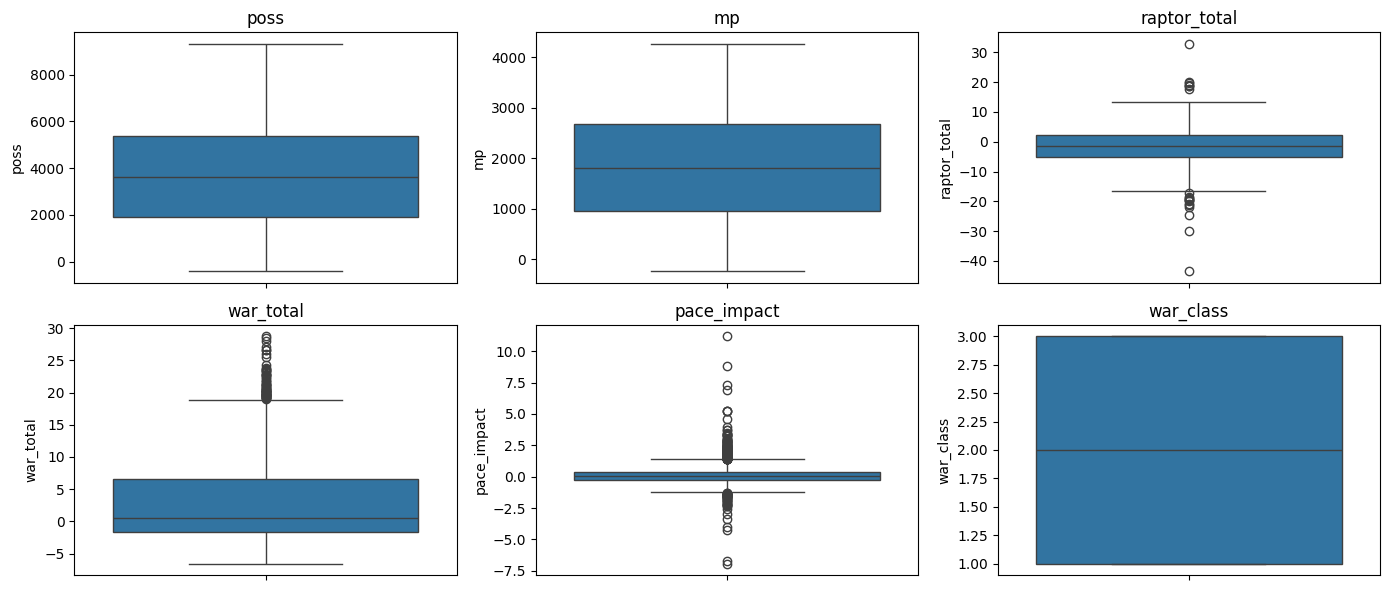

In [11]:
from Problema1.src.visualization import plot_correlation_matrix, plot_boxplots
plot_correlation_matrix(df_dev)
plot_boxplots(df_dev, ['Diagnosis', 'CellType', 'GeneticMutation'])
# sns.pairplot(df_dev, hue='war_class', diag_kind='kde', palette='Set2')

In [12]:
from Problema1.src.preprocessing import clean_outliers
from Problema1.src.preprocessing import train_val_split
from Problema1.src.preprocessing import smote
df_dev.drop(columns=["war_total"], inplace=True)
df_test.drop(columns=["war_total"], inplace=True)
limits = {'poss': (0, np.inf), 'mp': (0, np.inf)}
clean_outliers(df_dev, limits)
clean_outliers(df_test, limits)
df_dev.dropna(inplace=True)
df_test.dropna(inplace=True)

print(df_dev['war_class'].value_counts(normalize=True))
train, val = train_val_split(df_dev, split=0.8, shuffle=True)
train_smote = smote(train, 'war_class', k=5)
print(train_smote['war_class'].value_counts(normalize=True))

war_class
2    0.351396
3    0.340619
1    0.307984
Name: proportion, dtype: float64
war_class
3    0.333333
2    0.333333
1    0.333333
Name: proportion, dtype: float64


In [13]:
# Separar features y target
X_train = train_smote.drop("war_class", axis=1)
y_train = train_smote["war_class"]
X_val = val.drop("war_class", axis=1)
y_val = val["war_class"]
X_test = df_test.drop("war_class", axis=1)
y_test = df_test["war_class"]

In [14]:
from Problema1.src.preprocessing import robust_fit, robust_transform
print(y_train.value_counts())
print(y_val.value_counts())

# Features a escalar
features_robust = ['poss', 'mp', 'raptor_total', 'pace_impact']
# features_minmax = ['poss', 'mp', 'raptor_total', 'pace_impact']

# Fit con train
mediana, iqr = robust_fit(X_train[features_robust])
# minimos, maximos = minmax_fit(X_train[features_minmax])

# Transform
X_train[features_robust] = robust_transform(X_train[features_robust], mediana, iqr)
X_val[features_robust] = robust_transform(X_val[features_robust], mediana, iqr)
X_test[features_robust] = robust_transform(X_test[features_robust], mediana, iqr)

# X_train[features_minmax] = minmax_transform(X_train[features_minmax], minimos, maximos)
# X_val[features_minmax] = minmax_transform(X_val[features_minmax], minimos, maximos)
# X_test[features_minmax] = minmax_transform(X_test[features_minmax], minimos, maximos)

war_class
3    1858
2    1858
1    1858
Name: count, dtype: int64
war_class
2    457
3    455
1    406
Name: count, dtype: int64


LDA
0.9075764328498512


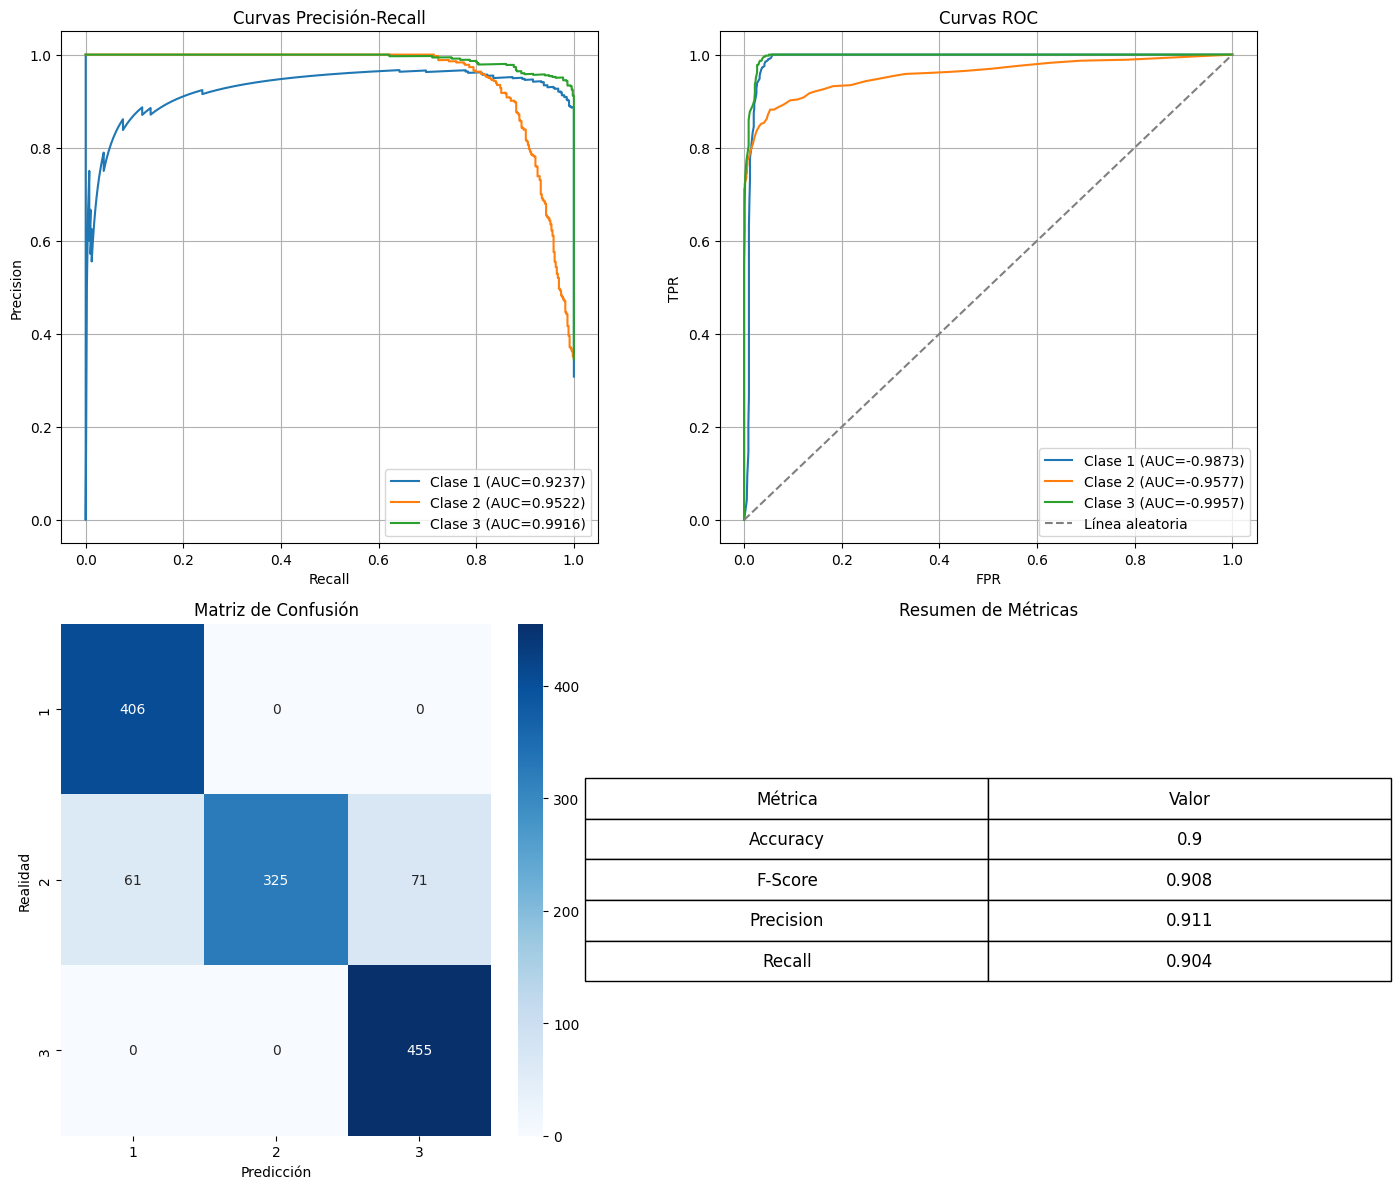

Mejor F-score: 0.9087344780993731 con lr=0.1, lambda=0
Logistic


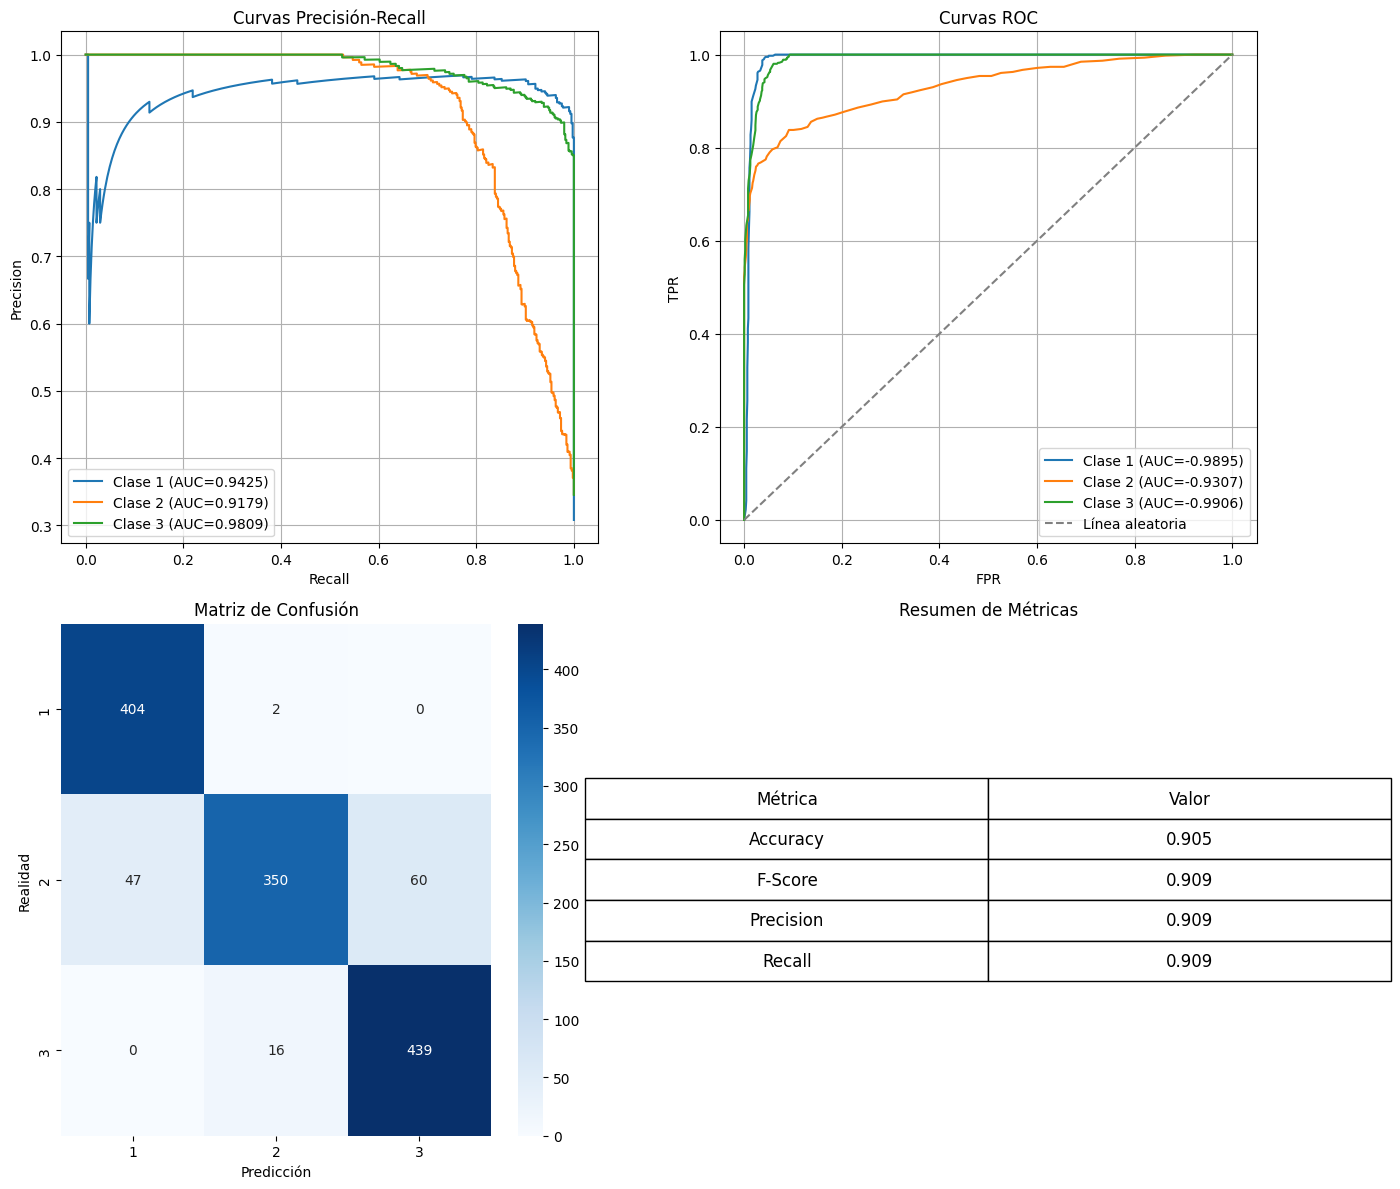

Entrenando Random Forest con n_trees=5, max_depth=5, min_samples_split=2
Entrenando Random Forest con n_trees=5, max_depth=10, min_samples_split=2
Entrenando Random Forest con n_trees=10, max_depth=5, min_samples_split=2
Entrenando Random Forest con n_trees=10, max_depth=10, min_samples_split=2
Mejor F-score: 0.9555095973130507 con n_trees=10, max_depth=5, min_samples_split=2
Random Forest
0.9555095973130507
0.9616325487562185


In [15]:
from Problema2.src.utils import train_best_random_forest, train_best_multiclass_logistic_model
from Problema2.src.models import LinearDiscriminantAnalysis
from Problema2.src.metrics import f_score
from Problema2.src.metrics import plot_all_metrics

model_lda = LinearDiscriminantAnalysis(X_train, y_train)
print("LDA")
y_pred = model_lda.predict(X_val)
print(f_score(y_val, y_pred))
y_prob = model_lda.predict_proba(X_val)
plot_all_metrics(y_val, y_prob, y_pred)


model_logistic = train_best_multiclass_logistic_model(X_train, y_train, X_val, y_val)
print("Logistic")
y_pred = model_logistic.predict(X_val)
y_prob = model_logistic.predict_proba(X_val)
plot_all_metrics(y_val, y_prob, y_pred)

model_forest = train_best_random_forest(X_train, y_train, X_val, y_val)
print("Random Forest")
y_pred = model_forest.predict(X_val)
print(f_score(y_val, y_pred))
y_pred = model_forest.predict(X_test)
print(f_score(y_test, y_pred))